In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import time 
import itertools 

In [2]:
#Education/Wage Data Set
train = pd.read_csv('Effect on Education')
train

print(train['Wage'].max())
print(train['Wage'].min())

2500
233


In [3]:
# split data into training and testing data
y = train.iloc[:, 0]
X = train.iloc[:, [1, 2, 3, 4, 5, 6]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## EDA
Looking for significant variables

In [4]:
corr = train.corrwith(train.Wage).sort_values(ascending=False)
print(corr)

#Here we observe relatively low linear correlations with Wage- lets look at correlation with logWage

Wage       1.000000
Logwage    0.963846
AFQT       0.349504
Educ       0.339001
Meduc      0.209436
Age        0.197729
Exper      0.019706
dtype: float64


In [5]:
logcorr = train.corrwith(train.Logwage).sort_values(ascending=False)
print(logcorr)

#Comprable correlation results- (may suggest low levels of Heteroskedasticity in error terms)

Logwage    1.000000
Wage       0.963846
AFQT       0.370152
Educ       0.321197
Meduc      0.214142
Age        0.197037
Exper      0.052629
dtype: float64


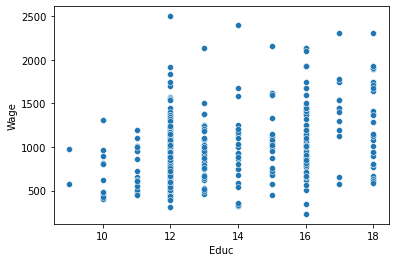

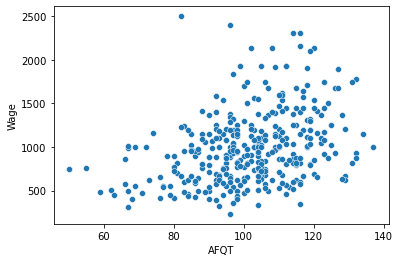

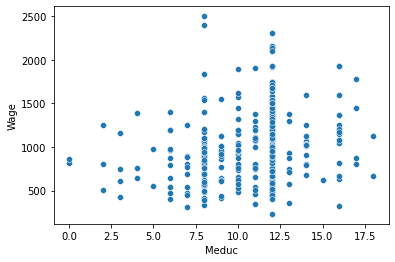

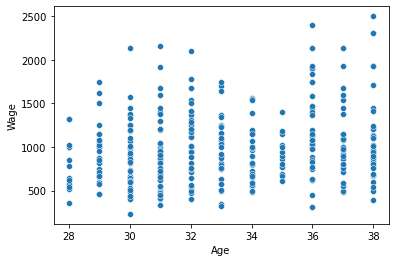

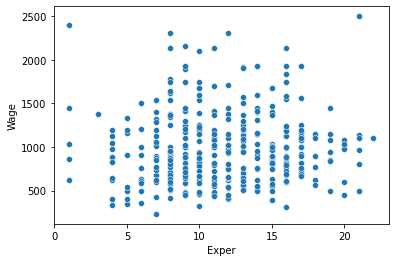

In [6]:
#Now, look for patterns in individual predictor scatterplots
sns.scatterplot(x=train.Educ, y=train.Wage)
plt.show()

sns.scatterplot(x=train.AFQT, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Meduc, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Age, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Exper, y=train.Wage)
plt.show()

Observationally, we see a distinct non-linear relationship in the AFQT plot.

Less clearly, there appears to be some non-linearity in the Meduc  and Educ plots.

<AxesSubplot:>

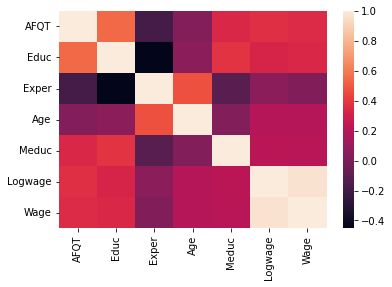

In [7]:
#Colinearity analysis
sns.heatmap(train.corr())

We see high correlations (>0.5) between: 
- Educ and AFQT
- Exper and Age

## VIF

In [8]:
train.corr()

,AFQT,Educ,Exper,Age,Meduc,Logwage,Wage
AFQT,1.000000,0.545440,-0.191140,0.033090,0.339986,0.370152,0.349504
Educ,0.545440,1.000000,-0.452313,0.055331,0.376856,0.321197,0.339001
Exper,-0.191140,-0.452313,1.000000,0.470650,-0.119142,0.052629,0.019706
Age,0.033090,0.055331,0.470650,1.000000,0.028174,0.197037,0.197729
Meduc,0.339986,0.376856,-0.119142,0.028174,1.000000,0.214142,0.209436
Logwage,0.370152,0.321197,0.052629,0.197037,0.214142,1.000000,0.963846
Wage,0.349504,0.339001,0.019706,0.197729,0.209436,0.963846,1.000000


In [9]:
X = train[['AFQT','Educ','Exper','Age','Meduc','Logwage','Wage']]

In [10]:
X.columns[1:]

Index(['Educ', 'Exper', 'Age', 'Meduc', 'Logwage', 'Wage'], dtype='object')

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

   feature          VIF
0    const  3039.395459
1     AFQT     1.569710
2     Educ     2.121719
3    Exper     1.894307
4      Age     1.476874
5    Meduc     1.209691
6  Logwage    14.770078
7     Wage    14.566142


VIF of constant is extremely high, which makes sense and we don't need further interpretation. VIFs of logwage and wage are high, so we should remove one of these two variables from the model (we removed logwage). Other than that, almost all VIFs are relatively close to 1, which means there is no severe multicollinearity.

In [12]:
#The easiest linear model

ols_object_0 = smf.ols(formula = 'Wage~AFQT+Educ+Exper+Age+Meduc', data = train)
model_log_0 = ols_object_0.fit()
model_log_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     16.99
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           5.06e-15
Time:                        16:16:34   Log-Likelihood:                -2578.6
No. Observations:                 352   AIC:                             5169.
Df Residuals:                     346   BIC:                             5192.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -975.3185    256.497     -3.802      0.000   -1479.809    -470.828
AFQT           5.8355      1.599      3.649      0.000       2.690       8.981
Educ          46.3832     12.578      3.688      0.000      21.645      71.121
Exper         12.3873      6.353      1.950      0.052      -0.109      24.883
Age           15.6494      7.904      1.980      0.049       0.104      31.195
Meduc          7.5716      7.537      1.005      0.316      -7.252      22.395
==============================================================================
Omnibus:                       49.169   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.710
Skew:                           0.862   Prob(JB):                     2.20e-17
Kurtosis:                       4.502   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#VIF for wage: 
1/(1-0.197)

1.2453300124533002

In [14]:
#No statistically significant relationship with Meduc

In [15]:
ols_object_1 = smf.ols(formula = 'Wage~AFQT+Educ+Exper+Age', data = train)
model_log_1 = ols_object_1.fit()
model_log_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     20.98
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.67e-15
Time:                        16:16:34   Log-Likelihood:                -2579.1
No. Observations:                 352   AIC:                             5168.
Df Residuals:                     347   BIC:                             5187.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -960.2109    256.060     -3.750      0.000   -1463.835    -456.587
AFQT           6.1056      1.576      3.873      0.000       3.005       9.206
Educ          49.3731     12.221      4.040      0.000      25.337      73.409
Exper         12.7411      6.344      2.008      0.045       0.264      25.218
Age           15.4526      7.902      1.956      0.051      -0.089      30.994
==============================================================================
Omnibus:                       48.653   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.173
Skew:                           0.866   Prob(JB):                     7.82e-17
Kurtosis:                       4.434   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
#VIF for wage:
1/(1-0.195)

1.2422360248447206

In [17]:
#No statistically significant relationship with Age

In [18]:
ols_object_2 = smf.ols(formula = 'Wage~AFQT+Educ+Exper', data = train)
model_log_2 = ols_object_2.fit()
model_log_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     26.48
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.88e-15
Time:                        16:16:34   Log-Likelihood:                -2581.0
No. Observations:                 352   AIC:                             5170.
Df Residuals:                     348   BIC:                             5185.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -617.8618    187.627     -3.293      0.001    -986.888    -248.836
AFQT           5.9646      1.581      3.772      0.000       2.855       9.074
Educ          56.9250     11.641      4.890      0.000      34.029      79.821
Exper         19.6625      5.286      3.720      0.000       9.266      30.059
==============================================================================
Omnibus:                       55.665   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.217
Skew:                           0.931   Prob(JB):                     9.45e-21
Kurtosis:                       4.679   Cond. No.                         985.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#VIF for wage:
1/(1-0.186)

1.2285012285012284

In [20]:
#revised model based on variables selection:
ols_object_3 = smf.ols(formula = 'Wage~I(AFQT**2)+Educ+Exper-1', data = train)
model_log_3 = ols_object_3.fit()
model_log_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Wage   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              852.0
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                   3.57e-160
Time:                        16:16:34   Log-Likelihood:                         -2583.1
No. Observations:                 352   AIC:                                      5172.
Df Residuals:                     349   BIC:                                      5184.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
I(AFQT ** 2)     0.0301      0.008      3.735      0.000       0.014       0.046
Educ            39.0676      6.850      5.703      0.000      25.595      52.540
Exper           12.6895      3.749      3.385      0.001       5.316      20.063
==============================================================================
Omnibus:                       58.289   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.998
Skew:                           0.980   Prob(JB):                     2.35e-21
Kurtosis:                       4.623   Cond. No.                     3.86e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#VIF for this model
1/(1-0.880)

8.333333333333334

This indicates moderate VIF

## Model
Naive model based on EDA results. Include visualizations

In [22]:
naivepred = train['Wage'].mean()
np.sqrt(((test.Wage - naivepred)**2).mean())

443.3458854283568

In [23]:
#Feel free to change this, wanted to get my EDA observations in a model
model = smf.ols(formula='Wage~I(AFQT**2)+Educ+Exper+Age+Meduc', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     16.88
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           6.24e-15
Time:                        16:16:34   Log-Likelihood:                -2578.8
No. Observations:                 352   AIC:                             5170.
Df Residuals:                     346   BIC:                             5193.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -690.3227    244.968     -2.818      0.005   -1172.137    -208.508
I(AFQT ** 2)     0.0290      0.008      3.587      0.000       0.013       0.045
Educ            46.2980     12.639      3.663      0.000      21.438      71.158
Exper           12.5470      6.355      1.974      0.049       0.048      25.046
Age             15.4948      7.907      1.960      0.051      -0.058      31.048
Meduc            8.1695      7.518      1.087      0.278      -6.618      22.957
==============================================================================
Omnibus:                       49.836   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.640
Skew:                           0.867   Prob(JB):                     8.39e-18
Kurtosis:                       4.535   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#VIF for wage: 
1/(1-0.196)

1.243781094527363

Very low $R^2$ value. Intercept term does not make sense in the context of our problem- as our predictors have little meaning as they approach zero. Let us force the regression through 0 by removing the intercept term.

In [25]:
model = smf.ols(formula='Wage~I(AFQT**2)+Educ+Exper+Age+Meduc-1', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Wage   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              509.2
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                   2.28e-157
Time:                        16:16:34   Log-Likelihood:                         -2582.8
No. Observations:                 352   AIC:                                      5176.
Df Residuals:                     347   BIC:                                      5195.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
I(AFQT ** 2)     0.0292      0.008      3.570      0.000       0.013       0.045
Educ            36.1123     12.232      2.952      0.003      12.054      60.171
Exper           12.2555      6.417      1.910      0.057      -0.366      24.877
Age             -0.1809      5.676     -0.032      0.975     -11.345      10.983
Meduc            5.7265      7.543      0.759      0.448      -9.108      20.561
==============================================================================
Omnibus:                       59.144   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.247
Skew:                           0.983   Prob(JB):                     4.63e-22
Kurtosis:                       4.684   Cond. No.                     7.54e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
#VIF for wage: 
1/(1-0.880)

8.333333333333334

In [27]:
#THIS IS OUR FINAL MODEL
## NEED TO RUN FINAL ANALYSIS ON THIS

modelfinal = smf.ols(formula='Wage~I(AFQT**2)*Educ+Exper-1', data=train).fit()
modelfinal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Wage   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              645.1
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                   1.69e-159
Time:                        16:16:34   Log-Likelihood:                         -2581.1
No. Observations:                 352   AIC:                                      5170.
Df Residuals:                     348   BIC:                                      5186.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
I(AFQT ** 2)          0.0015      0.017      0.091      0.928      -0.031       0.034
Educ                 32.3469      7.639      4.234      0.000      17.322      47.372
I(AFQT ** 2):Educ     0.0021      0.001      1.956      0.051   -1.21e-05       0.004
Exper                19.4391      5.085      3.823      0.000       9.438      29.440
==============================================================================
Omnibus:                       56.857   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.136
Skew:                           0.939   Prob(JB):                     1.33e-21
Kurtosis:                       4.741   Cond. No.                     6.64e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
pred_wage = modelfinal.predict(train)
np.sqrt(((train.Wage - pred_wage)**2).mean())

370.1347897346834

In [29]:
pred_wage = modelfinal.predict(test)
np.sqrt(((train.Wage - pred_wage)**2).mean())

nan

In [30]:
#VIF for wage: 
1/(1-0.194)

1.2406947890818858

In [31]:
pred_wage = modeltest.predict(train)
np.sqrt(((train.Wage - pred_wage)**2).mean())

NameError: name 'modeltest' is not defined

In [ ]:
pred_wage = modeltest.predict(test)
np.sqrt(((test.Wage - pred_wage)**2).mean())

## Stepwise Predictor Selection

In [ ]:
#BEST SUBSET SELECTION ALGORITHM 

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('Wage~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

BIC says that 1 predictor is the best. 

In [ ]:
best_subset_model = models_best.loc[1,'model']
models_best.loc[1,'model'].summary()

In [ ]:
# INCLUDING INTERACTIONS

#Creating a dataframe with all the predictors
X = train[['AFQT', 'Educ', 'Exper', 'Age', 'Meduc']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['AFQT', 'Educ', 'Exper', 'Age', 'Meduc']]

In [ ]:

#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
    
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

In [ ]:
best_sub_plots()

In [ ]:
best_interaction_model = models_best['model'][2]
best_interaction_model.summary()

The R-squared is really low still. But based on BIC, the most significant predictors are the the relation between AFQT with Education and Education with Experience. 

In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [ ]:
models_best = forward_selection()

In [ ]:
best_sub_plots()

In [ ]:
#BIC says 3 predictors 

best_fwd_reg_model = models_best['model'][3]
best_fwd_reg_model.summary()

In [ ]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [ ]:
models_best = backward_selection()

In [ ]:
best_sub_plots()

In [ ]:
best_bwd_reg_model = models_best['model'][2]
best_bwd_reg_model.summary()

In [ ]:
## Upgraded model using stepwise/VIF results #THIS SEEMS TO BE THE MOST INTERPRETABLE
testmodel = smf.ols(formula='Wage~I(AFQT**2)+Educ+Exper-1', data=train).fit()
testmodel.summary()
pred_wage = testmodel.predict(test)

train_pred_wage = testmodel.predict(train)

print(np.sqrt(((train.Wage - train_pred_wage)**2).mean()))
print(np.sqrt(((test.Wage - pred_wage)**2).mean()))



print("Model Performance:")
print("R-squared:", testmodel.rsquared)
print("Adjusted R-squared:", testmodel.rsquared_adj)

# print("Train RMSE:", np.sqrt(((train.Wage - pred_wage)**2).mean()))
print("Root Mean Squared Error (RMSE):", np.sqrt(testmodel.mse_resid))
print("Mean Absolute Error (MAE):", (np.abs(test.Wage - testmodel.predict(test))).mean())

testmodel.summary()

## Analysis
Check metrics/metrics for overfitting and assumption fulfillment

In [ ]:
# Fixing library names
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import time 
import itertools 

In [ ]:
pred_wage = model.predict(train)
np.sqrt(((train.Wage - pred_wage)**2).mean())

In [ ]:
pred_wage = model.predict(test)
np.sqrt(((test.Wage - pred_wage)**2).mean())

The RMSE values of the training data and the testing data are similar, indicating that there is no overfitting of the data. 

In [ ]:
pred_wage = model.predict(train)

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_wage.min(),pred_wage.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')

In [ ]:
pred_wage = model.predict(test)

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_wage.min(),pred_wage.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')

The model seems to satisfy the non-linearity assumption, as we do not observe a strong pattern in the residuals around the line Residuals = 0. Residuals are distributed more or less in a similar manner on both sides of the blue line for all fitted values. We observe that the constant variance assumption is also satisfied. 

In [ ]:
out = model.outlier_test()
np.sum((np.abs(out.student_resid)>3))

In [ ]:
influence = model.get_influence()
leverage = influence.hat_matrix_diag

sns.set(rc={'figure.figsize':(15,8)})
sm.graphics.influence_plot(model);
out = model.outlier_test()
average_leverage = (model.df_model+1)/model.nobs
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

In [ ]:
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))
train.shape[0]-train_filtered.shape[0]

There doesn't seem to be any influential points to filter out. 

## Optimization 
Interaction terms, Transformations, Outliers, Colinearity, etc.

We see high correlations (>0.5) between: 
- Educ and AFQT
- Exper and Age

## Updated Model and Analysis
Report Metrics and assumption status of current model. Output results.

In [ ]:
model.summary()

In [ ]:
# Model assumptions
print("Model Assumptions:")
print("Predictors and the response variable should be linear.")
sns.scatterplot(data=train, x='AFQT', y='Wage')
plt.title("Linearity: AFQT vs Wage")
plt.show()

print("- Independence: The observations should be independent of each other.")
# No code needed - this is assumed to be true unless otherwise stated.

print("The errors should be normally distributed.")
sns.histplot(data=model.resid, kde=True)
plt.title("Normality: Residuals")
plt.show()

print("Homoscedasticity")
sns.scatterplot(data=train, x=model.predict(), y=model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Homoscedasticity: Fitted Values vs Residuals")
plt.show()


In [ ]:
# Model performance
print("Model Performance:")
print("R-squared:", model.rsquared)
print("Adjusted R-squared:", model.rsquared_adj)
print("Root Mean Squared Error (RMSE):", np.sqrt(model.mse_resid))
print("Mean Absolute Error (MAE):", (np.abs(test.Wage - model.predict(test))).mean())